# Connect ke Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
pip install category_encoders

# Import


In [0]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support, roc_auc_score)
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import category_encoders as ce
from sklearn.impute import KNNImputer 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# All Functions

In [0]:
def measure_y(y_real, y_pred):
  print("Accuracy Score", accuracy_score(y_real, y_pred))
  print("Roc-Auc Score", roc_auc_score(y_real, y_pred))
  print(classification_report(y_real, y_pred))

def train_val_test_split(dataset, val_partition = 0.2, test_partition = 0.2):
  X, X_test, y, y_test = train_test_split(dataset[features], dataset[target], test_size = test_partition, random_state = 10, stratify=dataset[target])
  X_train, X_val, y_train, y_val =  train_test_split(X, y, test_size = val_partition, random_state = 10, stratify=y)

  return X_train, X_val, X_test, y_train, y_val, y_test

def transform_categorical_data_countencode(dataset):
  count_enc = ce.CountEncoder()
  count_encoded = count_enc.fit_transform(dataset[categorical_features])

  non_categorical = dataset.columns.drop(categorical_features)
  dataset_copy = dataset[non_categorical]
  dataset_copy = dataset_copy.join(count_encoded)

  # imputer = KNNImputer()
  # dataset_copy[features] = imputer.fit_transform(dataset_copy[features])

  return dataset_copy

def transform_categorical_data_catboostencoder(dataset, target):
  target_enc = ce.CatBoostEncoder(cols=categorical_features)
  target_enc.fit(dataset[categorical_features], target)

  non_categorical = dataset.columns.drop(categorical_features)
  dataset_copy = dataset[non_categorical]
  dataset_copy = dataset_copy.join(target_enc.transform(dataset[categorical_features]))

  # imputer = KNNImputer()
  # dataset_copy[features] = imputer.fit_transform(dataset_copy[features])

  return dataset_copy

# Check Dataset

In [0]:
print(dataset_after.columns)
features = ['Umur', 'Kelas Pekerja', 'Berat Akhir', 'Pendidikan',
       'Jmlh Tahun Pendidikan', 'Status Perkawinan', 'Pekerjaan',
       'Jenis Kelamin', 'Keuntungan Kapital', 'Kerugian Capital',
       'Jam per Minggu']
categorical_features = ['Kelas Pekerja', 'Pendidikan', 'Status Perkawinan',
                        'Pekerjaan', 'Jenis Kelamin']
target = 'Gaji'

Index(['id', 'Umur', 'Kelas Pekerja', 'Berat Akhir', 'Pendidikan',
       'Jmlh Tahun Pendidikan', 'Status Perkawinan', 'Pekerjaan',
       'Jenis Kelamin', 'Keuntungan Kapital', 'Kerugian Capital',
       'Jam per Minggu', 'Gaji'],
      dtype='object')


In [0]:
dataset_after = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/SanberCode/Week 4/Tugas Akhir/Pendapatan.csv')
dataset_after.head()

dataset_test = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/SanberCode/Week 4/Tugas Akhir/Pendapatan_test.csv')
print(dataset_test[categorical_features].head(10))

                   Kelas Pekerja  ... Jenis Kelamin
0               Pemerintah Lokal  ...     Perempuan
1                     Wiraswasta  ...         Laki2
2            Pemerintah Provinsi  ...         Laki2
3                     Wiraswasta  ...         Laki2
4                              ?  ...     Perempuan
5                     Wiraswasta  ...         Laki2
6                     Wiraswasta  ...         Laki2
7                     Wiraswasta  ...         Laki2
8  Pekerja Bebas Bukan Perusahan  ...         Laki2
9  Pekerja Bebas Bukan Perusahan  ...         Laki2

[10 rows x 5 columns]


In [0]:
dataset_after.describe()

,id,Umur,Berat Akhir,Jmlh Tahun Pendidikan,Keuntungan Kapital,Kerugian Capital,Jam per Minggu,Gaji
count,38393.000000,38393.000000,3.839300e+04,38393.000000,3.839300e+04,3.839300e+04,38393.000000,38393.000000
mean,24015.248535,38.673925,1.897238e+05,10.082828,1.518659e+07,1.212665e+06,40.440627,0.239497
std,13872.059919,13.694678,1.055764e+05,2.574543,1.044373e+08,5.613945e+06,12.382695,0.426782
min,0.000000,17.000000,1.228500e+04,1.000000,0.000000e+00,0.000000e+00,1.000000,0.000000
25%,11989.000000,28.000000,1.177510e+05,9.000000,0.000000e+00,0.000000e+00,40.000000,0.000000
50%,24050.000000,37.000000,1.783850e+05,10.000000,0.000000e+00,0.000000e+00,40.000000,0.000000
75%,36031.000000,48.000000,2.376300e+05,12.000000,0.000000e+00,0.000000e+00,45.000000,0.000000
max,47991.000000,90.000000,1.490400e+06,16.000000,1.399986e+09,6.098400e+07,99.000000,1.000000


In [0]:
dataset_after['Gaji'].value_counts()

0    29198
1     9195
Name: Gaji, dtype: int64

In [0]:
# more_than_zero = dataset_after['Keuntungan Kapital'] > 0
more_than_zero = dataset_after['Kerugian Capital'] > 0
# dataset_after[more_than_zero].head(10)
dataset_after[more_than_zero].head(30)

,id,Umur,Kelas Pekerja,Berat Akhir,Pendidikan,Jmlh Tahun Pendidikan,Status Perkawinan,Pekerjaan,Jenis Kelamin,Keuntungan Kapital,Kerugian Capital,Jam per Minggu,Gaji
7,24735,60,?,141221,Sarjana,13,Menikah,?,Laki2,0.0,30282000.0,25.0,0
18,14753,56,Wiraswasta,99359,SMA,9,Cerai,Pemuka Agama,Perempuan,0.0,22638000.0,40.0,0
66,3709,41,Pemerintah Lokal,343079,Sarjana,13,Menikah,Spesialis,Perempuan,0.0,24360000.0,20.0,0
69,1709,43,Wiraswasta,201723,Master,14,Menikah,Ekesekutif Managerial,Laki2,0.0,26628000.0,40.0,1
118,24968,58,Wiraswasta,100313,Pendidikan Tinggi,10,Menikah,Penjaga,Laki2,0.0,26628000.0,40.0,1
142,45183,36,Pemerintah Lokal,322770,Pendidikan Tinggi,10,Menikah,Spesialis,Laki2,0.0,26418000.0,40.0,1
149,18364,30,Pekerja Bebas Bukan Perusahan,146161,SMA,9,Menikah,Ekesekutif Managerial,Laki2,0.0,26418000.0,50.0,1
152,11093,55,Wiraswasta,124808,D4,11,Menikah,Spesialis,Laki2,0.0,27678000.0,50.0,1
165,1392,59,Wiraswasta,226922,SMA,9,Cerai,Sales,Perempuan,0.0,24668000.0,30.0,0
207,10269,40,Pekerja Bebas Bukan Perusahan,284706,Sekolah Professional,15,Menikah,Spesialis,Laki2,0.0,27678000.0,60.0,1


In [0]:
dataset_after.dtypes

id                         int64
Umur                       int64
Kelas Pekerja             object
Berat Akhir                int64
Pendidikan                object
Jmlh Tahun Pendidikan      int64
Status Perkawinan         object
Pekerjaan                 object
Jenis Kelamin             object
Keuntungan Kapital       float64
Kerugian Capital         float64
Jam per Minggu           float64
Gaji                       int64
dtype: object

In [0]:
# Check semua object value untuk menemukan nilai diluar keharusan
print(dataset_after['Status Perkawinan'].value_counts())
print()
print(dataset_after['Pendidikan'].value_counts())
print()
print(dataset_after['Kelas Pekerja'].value_counts())
print()
print(dataset_after['Jenis Kelamin'].value_counts())
print()
print(dataset_after['Pekerjaan'].value_counts())

Menikah                 17640
Belum Pernah Menikah    12650
Cerai                    5200
Berpisah                 1203
Janda                    1178
Menikah LDR               522
Name: Status Perkawinan, dtype: int64

SMA                     12430
Pendidikan Tinggi        8529
Sarjana                  6320
Master                   2093
D4                       1603
11th                     1407
D3                       1260
10th                     1096
7th-8th                   722
Sekolah Professional      666
9th                       604
12th                      509
Doktor                    477
5th-6th                   418
1st-4th                   195
SD                         64
Name: Pendidikan, dtype: int64

Wiraswasta                       26589
Pekerja Bebas Bukan Perusahan     3072
Pemerintah Lokal                  2454
?                                 2204
Pemerintah Negara                 1579
Pekerja Bebas Perusahaan          1345
Pemerintah Provinsi               1

In [0]:
dataset_after = dataset_after.replace({'Status Perkawinan': {'Cerai' : 0, 'Menikah': 1, 'Belum Pernah Menikah': 2 , 'Janda' : 3, 'Berpisah' : 4,
       'Menikah LDR' : 4}})

dataset_after =dataset_after.replace({'Pendidikan' : {'D4' : 0, 'SMA' : 1, 'Pendidikan Tinggi' : 2, '11th' : 3, '10th' : 4, 'D3' : 5, 'Sarjana' : 6,'Master' : 7, '7th-8th' : 8, '1st-4th' : 9, 'Sekolah Professional' : 10, '9th' : 11, '12th' : 12, 'Doktor' : 13, '5th-6th' : 14, 'SD' : 15}})

dataset_after = dataset_after.replace({'Jenis Kelamin' : {'Perempuan' : 0, 'Laki2' : 1}})

dataset_after = dataset_after.replace({'Kelas Pekerja' : {'?': 0,'Pemerintah Lokal' : 1, 'Wiraswasta': 2 , 'Pemerintah Provinsi' : 3,
       'Pekerja Bebas Bukan Perusahan' : 4, 'Pekerja Bebas Perusahaan' : 5,
       'Pemerintah Negara' : 6, 'Tanpa di Bayar' : 7, 'Tidak Pernah Bekerja' : 8}})

dataset_after = dataset_after.replace({'Pekerjaan' : {'?' : 0, 'Pemuka Agama' : 1, 'Mesin Inspeksi' : 2, 'Ekesekutif Managerial' : 3, 
       'Pembersih' : 4, 'Sales' : 5, 'Perbaikan Kerajinan' : 6, 'Petani' : 7, 'Spesialis' : 8,
       'Servis Lainnya' : 9, 'Supir' : 10, 'Tech-support' : 11, 'Asisten Rumah Tangga' : 12,
       'Penjaga' : 13, 'Tentara' : 14}})


dataset_test = dataset_test.replace({'Status Perkawinan': {'Cerai' : 0, 'Menikah': 1, 'Belum Pernah Menikah': 2 , 'Janda' : 3, 'Berpisah' : 4,
       'Menikah LDR' : 4}})

dataset_test =dataset_test.replace({'Pendidikan' : {'D4' : 0, 'SMA' : 1, 'Pendidikan Tinggi' : 2, '11th' : 3, '10th' : 4, 'D3' : 5, 'Sarjana' : 6,'Master' : 7, '7th-8th' : 8, '1st-4th' : 9, 'Sekolah Professional' : 10, '9th' : 11, '12th' : 12, 'Doktor' : 13, '5th-6th' : 14, 'SD' : 15}})

dataset_test = dataset_test.replace({'Jenis Kelamin' : {'Perempuan' : 0, 'Laki2' : 1}})

dataset_test = dataset_test.replace({'Kelas Pekerja' : {'?': 0,'Pemerintah Lokal' : 1, 'Wiraswasta': 2 , 'Pemerintah Provinsi' : 3,
       'Pekerja Bebas Bukan Perusahan' : 4, 'Pekerja Bebas Perusahaan' : 5,
       'Pemerintah Negara' : 6, 'Tanpa di Bayar' : 7, 'Tidak Pernah Bekerja' : 8}})

dataset_test = dataset_test.replace({'Pekerjaan' : {'?' : 0, 'Pemuka Agama' : 1, 'Mesin Inspeksi' : 2, 'Ekesekutif Managerial' : 3, 
       'Pembersih' : 4, 'Sales' : 5, 'Perbaikan Kerajinan' : 6, 'Petani' : 7, 'Spesialis' : 8,
       'Servis Lainnya' : 9, 'Supir' : 10, 'Tech-support' : 11, 'Asisten Rumah Tangga' : 12,
       'Penjaga' : 13, 'Tentara' : 14}})

In [0]:
dataset_test

,id,Umur,Kelas Pekerja,Berat Akhir,Pendidikan,Jmlh Tahun Pendidikan,Status Perkawinan,Pekerjaan,Jenis Kelamin,Keuntungan Kapital,Kerugian Capital,Jam per Minggu
0,47933,30,Pemerintah Lokal,99761,D4,11,Cerai,Pemuka Agama,Perempuan,0.0,0.0,40.0
1,44213,28,Wiraswasta,202206,SMA,9,Menikah,Mesin Inspeksi,Laki2,0.0,0.0,50.0
2,20823,34,Pemerintah Provinsi,199934,Pendidikan Tinggi,10,Menikah,Pemuka Agama,Laki2,0.0,0.0,40.0
3,40565,51,Wiraswasta,373448,Pendidikan Tinggi,10,Menikah,Ekesekutif Managerial,Laki2,0.0,28028000.0,40.0
4,9860,20,?,144685,Pendidikan Tinggi,10,Belum Pernah Menikah,?,Perempuan,0.0,22428000.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9594,13587,58,Pemerintah Negara,159021,9th,5,Menikah,Petani,Laki2,0.0,0.0,40.0
9595,33231,45,Pekerja Bebas Bukan Perusahan,144086,11th,7,Menikah,Perbaikan Kerajinan,Laki2,0.0,0.0,50.0
9596,18614,20,Wiraswasta,238685,Pendidikan Tinggi,10,Belum Pernah Menikah,Servis Lainnya,Perempuan,0.0,0.0,32.0
9597,37566,41,Pemerintah Lokal,249039,SMA,9,Berpisah,Pemuka Agama,Perempuan,0.0,0.0,40.0


In [0]:
kerja = dataset_after['Kelas Pekerja'] == 'Tidak Pernah Bekerja'
dataset_after['Gaji'][kerja].value_counts()

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


Series([], Name: Gaji, dtype: int64)

# Pilih Fitur

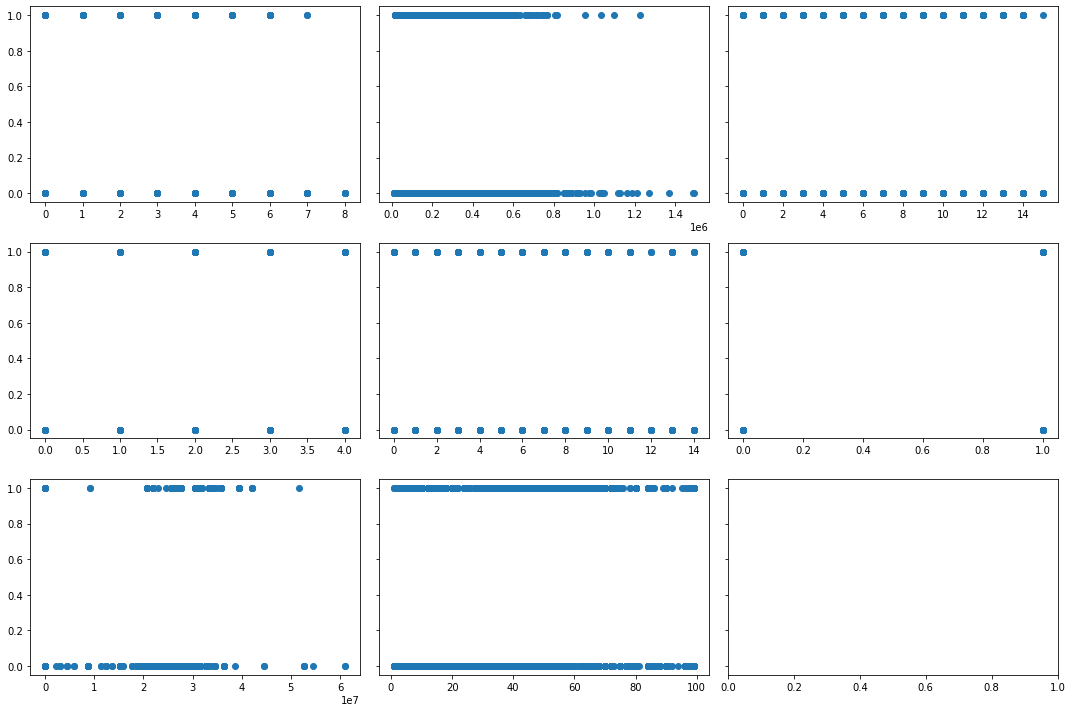

In [0]:
fig, ax = plt.subplots(figsize=(15, 10), nrows = 3, ncols = 3, sharey=True)

ncols = 3
nrows = 4

i = 0
j = 0

for feature in features[1:len(features)+1]:
  if j < ncols:
    ax[i][j].scatter(dataset_after[feature], dataset_after['Gaji'])
    if dataset_after[feature].dtypes == 'object':
      ax[i][j].tick_params(axis='x', labelrotation=90) 
    j += 1
  else:
    j = 0
    i += 1

plt.tight_layout()
plt.show()

In [0]:
# dataset_transformed = transform_categorical_data_countencode(dataset_after)

In [0]:
is_pemerintah_negara = dataset["Kelas Pekerja"] == 'Pemerintah Negara'
print(dataset[categorical_features].head())
print(dataset_transformed[categorical_features].head())
print(dataset_test[categorical_features].head())
print(dataset_transformed_test[categorical_features].head())

                   Kelas Pekerja  ... Jenis Kelamin
0              Pemerintah Negara  ...         Laki2
1                     Wiraswasta  ...     Perempuan
2  Pekerja Bebas Bukan Perusahan  ...     Perempuan
3                     Wiraswasta  ...     Perempuan
4                     Wiraswasta  ...         Laki2

[5 rows x 5 columns]
   Kelas Pekerja  Pendidikan  Status Perkawinan  Pekerjaan  Jenis Kelamin
0           1579        2093              17640       4790          25708
1          26589       12430               5200       3859          12685
2           3072       12430               5200       4790          12685
3          26589       12430              12650       1650          12685
4          26589       12430              12650       1859          25708
  Kelas Pekerja Pendidikan Status Perkawinan Pekerjaan Jenis Kelamin
0         27247      27247             27247     27247         27247
1          1640       1640              1640      1640          1640
2         45206

In [0]:
# dataset_transformed = dataset_after.dropna(axis='columns')

In [0]:
print(X_val)

       Umur  Kelas Pekerja  ...  Kerugian Capital  Jam per Minggu
19314  49.0        26589.0  ...               0.0            40.0
11496  22.0        26589.0  ...               0.0            40.0
20843  22.0        26589.0  ...               0.0            15.0
21291  64.0         2204.0  ...               0.0            50.0
30054  52.0        26589.0  ...               0.0            45.0
...     ...            ...  ...               ...             ...
24937  42.0         3072.0  ...               0.0            50.0
2520   50.0        26589.0  ...               0.0            40.0
25352  36.0        26589.0  ...               0.0            40.0
16835  56.0        26589.0  ...               0.0            20.0
17134  26.0        26589.0  ...               0.0            50.0

[6143 rows x 11 columns]


In [0]:
# Trial with Feature Selection
# Keep 5 features
selector = SelectKBest(score_func=chi2, k=9)

X_new = selector.fit_transform(X_train[features], y_train)
X_new

selected_features = pd.DataFrame(selector.inverse_transform(X_new), 
                                 index=X_train.index, 
                                 columns=features)
selected_features.head()

,Umur,Kelas Pekerja,Berat Akhir,Pendidikan,Jmlh Tahun Pendidikan,Status Perkawinan,Pekerjaan,Jenis Kelamin,Keuntungan Kapital,Kerugian Capital,Jam per Minggu
28696,33.0,0.0,167771.0,2.0,10.0,4.0,0.0,0.0,0.0,0.0,30.0
102,24.0,0.0,220944.0,2.0,10.0,1.0,0.0,1.0,0.0,0.0,60.0
31323,38.0,0.0,290624.0,0.0,11.0,2.0,0.0,0.0,0.0,0.0,40.0
2788,53.0,0.0,281590.0,1.0,9.0,1.0,0.0,0.0,210336000.0,0.0,40.0
36176,20.0,0.0,258430.0,2.0,10.0,2.0,0.0,0.0,0.0,0.0,19.0


In [0]:
selected_columns = selected_features.columns[selected_features.var() != 0]

# Get the valid dataset with the selected features.
X_train[selected_columns].columns

Index(['Umur', 'Berat Akhir', 'Pendidikan', 'Jmlh Tahun Pendidikan',
       'Status Perkawinan', 'Jenis Kelamin', 'Keuntungan Kapital',
       'Kerugian Capital', 'Jam per Minggu'],
      dtype='object')

In [0]:
X_train = X_train[selected_columns]
X_val = X_val[selected_columns]
X_test = X_test[selected_columns]

In [0]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(dataset_after)

In [0]:
CV_NUMBER = 10

auc_list = []
recall_list = []

# Cross Validation
for idx in range(CV_NUMBER):

    # Create dataset for lightgbm
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    # Params
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'is_unbalance': True,
        'metric': 'auc',
        'num_leaves': 31,
        'learning_rate': 0.04,
        'bagging_fraction': 0.95,
        'feature_fraction': 0.98,
        'bagging_freq': 6,
        'max_depth': -1,
        'max_bin': 511,
        'min_data_in_leaf': 20,
        'verbose': 0,
        'seed': 23747 + 17 * idx
    }
    
    bst = lgb.train(params, lgb_train, num_boost_round=800, valid_sets=lgb_eval, early_stopping_rounds=20)    
    y_pred = bst.predict(X_val, num_iteration=bst.best_iteration)
    y_pred = np.round_(y_pred, 0)

    auc_list.append(roc_auc_score(y_val, y_pred))
    recall_list.append(recall_score(y_val, y_pred))

[1]	valid_0's auc: 0.877857
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's auc: 0.897585
[3]	valid_0's auc: 0.901427
[4]	valid_0's auc: 0.903074
[5]	valid_0's auc: 0.903379
[6]	valid_0's auc: 0.904642
[7]	valid_0's auc: 0.904982
[8]	valid_0's auc: 0.907036
[9]	valid_0's auc: 0.907685
[10]	valid_0's auc: 0.907835
[11]	valid_0's auc: 0.907912
[12]	valid_0's auc: 0.907516
[13]	valid_0's auc: 0.907402
[14]	valid_0's auc: 0.908499
[15]	valid_0's auc: 0.908772
[16]	valid_0's auc: 0.90977
[17]	valid_0's auc: 0.9099
[18]	valid_0's auc: 0.90996
[19]	valid_0's auc: 0.910372
[20]	valid_0's auc: 0.910563
[21]	valid_0's auc: 0.910811
[22]	valid_0's auc: 0.911109
[23]	valid_0's auc: 0.911227
[24]	valid_0's auc: 0.911333
[25]	valid_0's auc: 0.911568
[26]	valid_0's auc: 0.912073
[27]	valid_0's auc: 0.912401
[28]	valid_0's auc: 0.912481
[29]	valid_0's auc: 0.91271
[30]	valid_0's auc: 0.91283
[31]	valid_0's auc: 0.912977
[32]	valid_0's auc: 0.913562
[33]	valid_0's auc: 0.913

# Test Model

In [0]:
X_train, X_test, y_train, y_test = train_test_split(dataset_after[features], dataset_after[target], test_size = 0.2, random_state = 10, stratify=dataset_after[target])

# lgb_model = lgb.LGBMClassifier()
# cv = RepeatedStratifiedKFold(n_splits=100, n_repeats=4, random_state=1)
# n_scores = cross_val_score(lgb_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

# make a single prediction

In [0]:
# X_train = transform_categorical_data_catboostencoder(X_train, y_train)
# X_test = transform_categorical_data_catboostencoder(X_test, y_test)

In [0]:
# X_train = X_train[selected_columns]
# X_val = X_val[selected_columns]
# X_test = X_test[selected_columns]

In [0]:
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 3, # Updated from nthread
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'}

gridParams = {
    'learning_rate': [0.005],
    'n_estimators': [40],
    'num_leaves': [6,8,12,16],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501], # Updated from 'seed'
    'colsample_bytree' : [0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

In [0]:
lgb_model = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 5, 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])
# lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_bin=512,
               max_depth=-1, min_child_samples=5, min_child_weight=1,
               min_split_gain=0.5, n_estimators=100, n_jobs=5, num_leaves=31,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, scale_pos_weight=1, silent=True, subsample=1,
               subsample_for_bin=200, subsample_freq=1)

In [0]:
rscv = RandomizedSearchCV(lgb_model, gridParams, n_iter=30, verbose=2, scoring='roc_auc', cv=5)
# grid = GridSearchCV(lgb_model, gridParams, verbose=2, cv=4, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 4 folds for each of 96 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:  1.5min finished


GridSearchCV(cv=4, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_bin=512,
                                      max_depth=-1, min_child_samples=5,
                                      min_child_weight=1, min_split_gain=0.5,
                                      n_estimators=100, n_jobs=5, num_leaves=31,
                                      objective='binary', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0,...
             iid='deprecated', n_jobs=-1,
             param_grid={'boosting_type': ['gbdt'],
                         'colsample_bytree': [0.65, 0.66],
                         'learning_rate': [0.005], 'n_estimators': [40],
                         'num_leaves': [6, 8, 12, 16], 'objective': ['binary'],
     

In [0]:
print(grid.best_params_)
print(grid.best_score_)

{'boosting_type': 'gbdt', 'colsample_bytree': 0.65, 'learning_rate': 0.005, 'n_estimators': 40, 'num_leaves': 16, 'objective': 'binary', 'random_state': 501, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.75}
0.9033578740622501


In [0]:
params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate']
params['num_leaves'] = grid.best_params_['num_leaves']
params['reg_alpha'] = grid.best_params_['reg_alpha']
params['reg_lambda'] = grid.best_params_['reg_lambda']
params['subsample'] = grid.best_params_['subsample']

In [0]:
lgbm = lgb.train(params,
                 lgb.Dataset(X_train, y_train),
                #  early_stopping_rounds= 50,
                #  valid_sets=[X_val, y_val],
                 verbose_eval= 4
                 )


In [0]:
afc_test_y = lgb_model.predict(X_test, num_iteration=bst.best_iteration)
afc_test_y = np.round_(afc_test_y, 0)
train_predict_y = lgb_model.predict(X_train, num_iteration=bst.best_iteration)
train_predict_y = np.round_(train_predict_y, 0)

In [0]:
# Train
measure_y(y_train, train_predict_y)
print(confusion_matrix(y_train, train_predict_y, labels=[1, 0]))
print()
# Artificial Test
measure_y(y_test, afc_test_y)
print(confusion_matrix(y_test, afc_test_y, labels=[1, 0]))
print()

Accuracy Score 0.8739662694536693
Roc-Auc Score 0.8021666829393732
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     23358
           1       0.78      0.66      0.72      7356

    accuracy                           0.87     30714
   macro avg       0.84      0.80      0.82     30714
weighted avg       0.87      0.87      0.87     30714

[[ 4887  2469]
 [ 1402 21956]]

Accuracy Score 0.855189477796588
Roc-Auc Score 0.7773855281682273
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      5840
           1       0.73      0.63      0.68      1839

    accuracy                           0.86      7679
   macro avg       0.81      0.78      0.79      7679
weighted avg       0.85      0.86      0.85      7679

[[1155  684]
 [ 428 5412]]



In [0]:
false_positive_rate, recall, thresholds = roc_curve(y_test, afc_test_y)
roc_auc = auc(false_positive_rate, recall)
print('AUC score:', roc_auc)

AUC score: 0.5122349102773246


# Roc Curve

# Prediction

In [0]:
dataset_transformed[categorical_features].head(10)

,Kelas Pekerja,Pendidikan,Status Perkawinan,Pekerjaan,Jenis Kelamin
0,1579,2093,17640,4790,25708
1,26589,12430,5200,3859,12685
2,3072,12430,5200,4790,12685
3,26589,12430,12650,1650,12685
4,26589,12430,12650,1859,25708
5,26589,12430,17640,4323,25708
6,26589,12430,17640,4788,25708
7,2204,6320,17640,2210,25708
8,26589,12430,12650,1650,25708
9,2204,12430,1203,2210,12685


In [0]:
y_test_pred = lgb_model.predict(dataset_test[features])
y_test_pred = np.round_(y_test_pred, 0)

In [0]:
s1 = pd.Series(dataset_test['id'])
s2 = pd.Series(y_test_pred)

In [0]:
frame = { 'id': s1, 'Gaji': s2 } 
  
submission = pd.DataFrame(frame)
submission['Gaji'] = submission['Gaji'].astype('int64') 

In [0]:
filename = 'Tugas_Akhir_sanbercode_7.csv'

submission.to_csv(filename, index=False)
# files.download(filename)

In [0]:
submission['Gaji'].value_counts()

0    7699
1    1900
Name: Gaji, dtype: int64

In [0]:
dataset_test